In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai2.vision.all import *
from efficientnet_pytorch import EfficientNet

In [3]:
np.random.seed(1773)

In [4]:
md_ef = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)

Loaded pretrained weights for efficientnet-b0


In [5]:
CSV_PATH = "/home/ubuntu/auto/dataset/train.csv"
df = pd.read_csv(CSV_PATH)

In [6]:
exp_time = str(datetime.now().replace(second=0, microsecond=0)).replace(" ", "_")
SIZE = 255
BS = 32
GPU = 0
EXP_NAME = "{}-{}-{}".format(BS, SIZE, exp_time)
print(EXP_NAME)

32-255-2020-04-04_12:25:00


In [8]:
item_tfms = [Resize(SIZE)]
dls = ImageDataLoaders.from_df(df=df, path="/home/ubuntu/auto/dataset/train", 
                                item_tfms=item_tfms, valid_pct=0.2,
                                bs=BS, num_workers=16, device=GPU)

In [9]:
x,y = dls.one_batch()
xm,ym = x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

In [10]:
stats = (xm,ym)

In [11]:
item_tfms = [Resize(SIZE)]
batch_tfms=[*aug_transforms(size=128, min_scale=0.75),
                               Normalize.from_stats(*stats)]

In [12]:
dls = ImageDataLoaders.from_df(df=df, path="/home/ubuntu/auto/dataset/train", 
                                item_tfms=item_tfms, valid_pct=0.2,batch_tfms=batch_tfms,
                                bs=BS, num_workers=16, device=GPU)

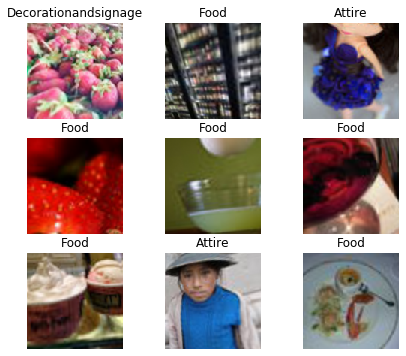

In [13]:
dls.show_batch(max_n=9, figsize=(7,6))

In [14]:
print(dls.vocab)
len(dls.vocab),dls.c

(#4) ['Attire','Decorationandsignage','Food','misc']


(4, 4)

In [15]:
learn = Learner(dls, md_ef, opt_func=ranger, cbs= MixUp()).to_fp16()

In [ ]:
learn.show_results(figsize=(7,6))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,6), dpi=60)
interp.most_confused(min_val=10)

In [ ]:
path = "/home/ubuntu/auto/dataset/test"
imgs = get_image_files(path)
test_dl = dls.test_dl(imgs)

In [ ]:
preds,targs = learn.tta()

In [ ]:
accuracy(preds, targs).item()

In [ ]:
preds, _ = learn.get_preds(dl=test_dl)

In [ ]:
ids = [i for i in os.listdir(path)]
submission = pd.DataFrame({'Image': ids, 'Attire': preds[:,0], 'Decorationandsignage': preds[:,1], 'Food': preds[:,2], 'misc': preds[:,2]})

In [ ]:
for i, c in enumerate(dls.vocab):
    submission[c] = preds[:,i]

In [ ]:
sub = submission.drop("Image", axis=1)

In [ ]:
id_class = sub.idxmax(axis=1).tolist()

In [ ]:
submission = pd.DataFrame({'Image': ids, 'Class': id_class})

In [ ]:
submission.head()

In [ ]:
submission.to_csv('/home/ubuntu/auto/submission/{}.csv'.format(EXP_NAME), index=False)